| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-530 Data Analystics and Internet of Things |
| **Assignment** | 4.1 - LSTM Predictor Models |
| **GitHub Repository** | https://github.com/ploung/AAI-530-IoT-Assignment-4.1.git |

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [27]:
#Load your data into a pandas dataframe here
try:
    file_path = "household_power_clean/household_power_clean.csv"
    df = pd.read_csv(file_path, delimiter=",")
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File not found: {file_path}")

Data loaded successfully.


In [4]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,29,2006-12-16,17:53:00,3.178,0.000,235.28,13.4,0.0,0.0,17.0,2006-12-16 17:53:00,4.338733,0.260667,234.631333,18.600000,1166291580
1,30,2006-12-16,17:54:00,2.720,0.000,235.06,11.6,0.0,0.0,17.0,2006-12-16 17:54:00,4.288867,0.246733,234.638667,18.373333,1166291640
2,31,2006-12-16,17:55:00,3.758,0.076,234.17,16.4,0.0,0.0,17.0,2006-12-16 17:55:00,4.235467,0.234733,234.656667,18.153333,1166291700
3,32,2006-12-16,17:56:00,4.342,0.090,233.77,18.4,0.0,0.0,16.0,2006-12-16 17:56:00,4.201067,0.221133,234.672667,18.000000,1166291760
4,33,2006-12-16,17:57:00,4.512,0.000,233.62,19.2,0.0,0.0,17.0,2006-12-16 17:57:00,4.171867,0.204400,234.668667,17.873333,1166291820


In [5]:
#create your training and validation sets here

#assign size for data subset
subset_size = 0.01

#take random data subset
df = df.iloc[:, 3:11]  #select columns 3 to 10 (Global_intensity to Sub_metering_3)
df = df.sample(frac=subset_size, random_state=1234) #take 1% random sample of data

#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234)

In [6]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [7]:
train_df.head()

,index,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,670898,1.712,0.290,238.73,7.2,1.0,2.0,18.0,2008-03-29 09:11:00
1,456196,0.228,0.000,240.76,1.0,0.0,0.0,0.0,2007-11-01 06:41:00
2,1277010,0.378,0.090,240.46,1.6,1.0,0.0,1.0,2009-05-24 10:23:00
3,169015,0.398,0.234,239.71,1.8,0.0,1.0,0.0,2007-04-13 02:57:00
4,1264152,1.444,0.192,237.03,6.0,0.0,1.0,18.0,2009-05-15 12:05:00


## Normalize training and validation data

In [8]:
#select sensor columns for normalization (from 0 to 1). 
#Global_active_power is the target variable and Datetime are not normalized.
columns_to_normalize = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

scaler = preprocessing.MinMaxScaler()
train_df_normalize = pd.DataFrame(scaler.fit_transform(
    train_df[columns_to_normalize]), 
    columns=columns_to_normalize, 
    index=train_df.index)   

#recombine normalized columns with unnormalized target and datetime columns
join_df = train_df[['Datetime', 'Global_active_power']].join(train_df_normalize)
train_df = join_df.sort_values('Datetime').reset_index(drop=True) #sort by datetime and reset index

In [9]:
# normalize validation data
val_df_normalize = pd.DataFrame(scaler.transform(val_df[columns_to_normalize]), 
                                columns=columns_to_normalize, 
                                index=val_df.index)

#recombine normalized columns with unnormalized target and datetime columns
val_join_df = val_df[['Datetime', 'Global_active_power']].join(val_df_normalize)

# Step 3: Sort by datetime and reset index (same as train_df)
val_df = val_join_df.sort_values('Datetime').reset_index(drop=True)

print("Validation data after preprocessing:")
val_df.head()

Validation data after preprocessing:


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 18:26:00,4.868,0.000000,0.296377,0.530928,0.000000,0.013333,0.548387
1,2006-12-16 20:19:00,3.314,0.000000,0.268841,0.360825,0.000000,0.000000,0.548387
2,2006-12-17 07:17:00,2.356,0.061770,0.511957,0.247423,0.000000,0.000000,0.000000
3,2006-12-17 10:44:00,5.872,0.320534,0.275362,0.644330,0.461538,0.466667,0.548387
4,2006-12-17 13:44:00,1.810,0.171953,0.516304,0.190722,0.000000,0.000000,0.580645


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [10]:
seq_arrays = []
seq_labs = []

In [11]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for start in range(len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].values) #get sequence of GAP readings
    seq_labs.append(train_df['Global_active_power'].iloc[start+seq_length+ph]) #get GAP reading at predictive horizon

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [12]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [13]:
seq_arrays.shape


(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert function checks to see seq_arrays and seq_labs have the right shape; seq_arrays  shape is (16359, 30, 1) and seq_lab shap is (16359, ). It is important to have the right shape for feeding into the model. 

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [14]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2] #number of features used as input
nb_out = 1 #number of outputs

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, #number of LSTM units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3, #number of LSTM units
          return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=nb_out)) #number of output units
model.add(Activation('linear')) #linear activation for regression for predicting continuous values
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the model with sequence arrays and labels
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

c:\Users\Loung\USD\AAI-530-IoT\AAI-530-IoT-Assignment-4.1\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 3s - 82ms/step - loss: 1.5972 - mse: 1.5972 - val_loss: 0.9098 - val_mse: 0.9098
Epoch 2/100
32/32 - 0s - 10ms/step - loss: 1.1858 - mse: 1.1858 - val_loss: 0.9275 - val_mse: 0.9275
Epoch 3/100
32/32 - 0s - 10ms/step - loss: 1.1576 - mse: 1.1576 - val_loss: 0.9232 - val_mse: 0.9232
Epoch 4/100
32/32 - 0s - 10ms/step - loss: 1.1503 - mse: 1.1503 - val_loss: 0.9415 - val_mse: 0.9415
Epoch 5/100
32/32 - 0s - 10ms/step - loss: 1.1275 - mse: 1.1275 - val_loss: 0.9344 - val_mse: 0.9344
Epoch 6/100
32/32 - 0s - 10ms/step - loss: 1.1272 - mse: 1.1272 - val_loss: 0.9225 - val_mse: 0.9225
Epoch 7/100
32/32 - 0s - 10ms/step - loss: 1.1167 - mse: 1.1167 - val_loss: 0.9213 - val_mse: 0.9213
Epoch 8/100
32/32 - 0s - 10ms/step - loss: 1.1078 - mse: 1.1078 - val_loss: 0.9243 - val_mse: 0.9243
Epoch 9/100
32/32 - 0s - 10ms/step - loss: 1.0991 - mse: 1.0991 - val_loss: 0.9226 - val_mse: 0.9226
Epoch 10/100
32/32 - 0s - 10ms/step - loss: 1.0956 - mse: 1.0956 - val_loss: 0.9212 - 

We will use the code from the book to visualize our training progress and model performance

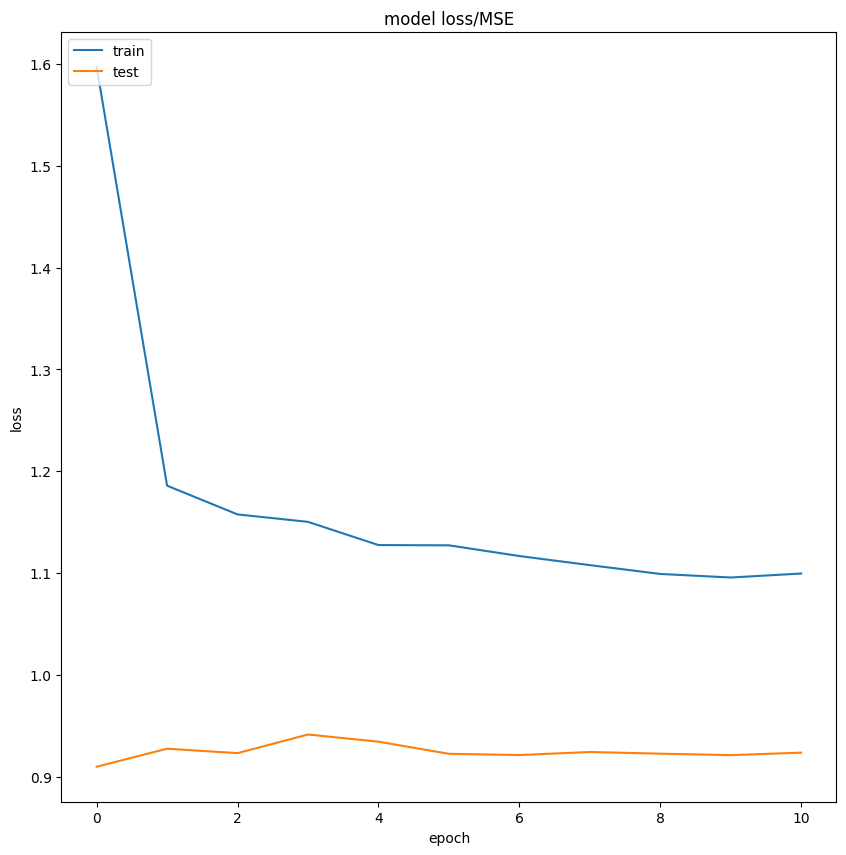

In [15]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The LSTM model expects input sequences of 30 consecutive datapoints and then predicts GAP value at the time defined by Prediction Horizon (PH). For validation, we only read in 2 consecutive datapoints, but the model expects 30 datapoints. We can address this issue by “padding” inputs when they are too short using **tf.keras.utils.pad_sequences** method with the following arguments:
- Sequences
- maxlen=30
- padding='pre', 
- value=0.0

padding=pre adds padding at the beginning of the input sequences, which is preferred for time series data and padded value = 0 (value=0.0). 

In [16]:
val_arrays = [] #input sequences for validation data
val_labs = [] #target predictions for validation data

#create list of GAP readings starting with a minimum of two readings
for seq_len in range(2, min(len(val_df), 31)):
    for start in range (len(val_df) - seq_length - ph):
        val_arrays.append(val_df[feat_cols].iloc[start:start+seq_length].values) #get sequence of GAP readings
        val_labs.append(val_df['Global_active_power'].iloc[start+seq_length+ph]) #get GAP reading at predictive horizon

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = keras.utils.pad_sequences(val_arrays, maxlen=seq_length, padding='pre', value=0.0) #pad with zeros at the beginning
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

3683/3683 - 6s - 2ms/step - loss: 1.1490 - mse: 1.1490

MSE: 1.1490367650985718
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


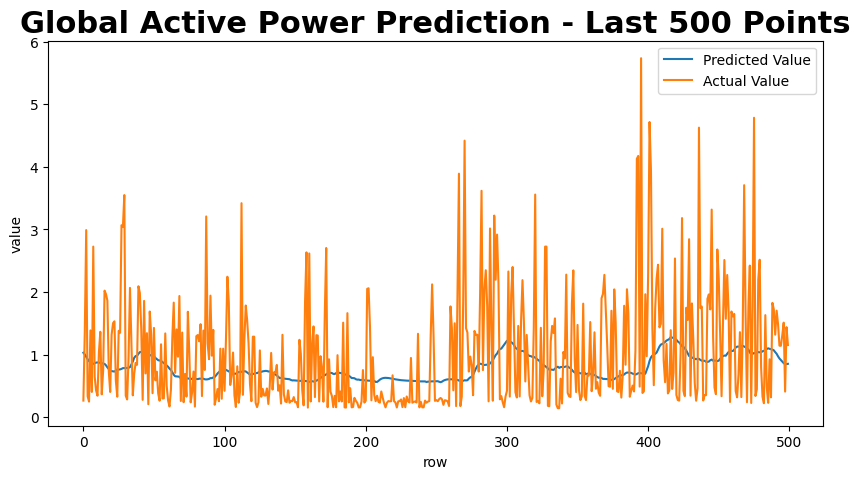

In [17]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None) #save predictions to csv file

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

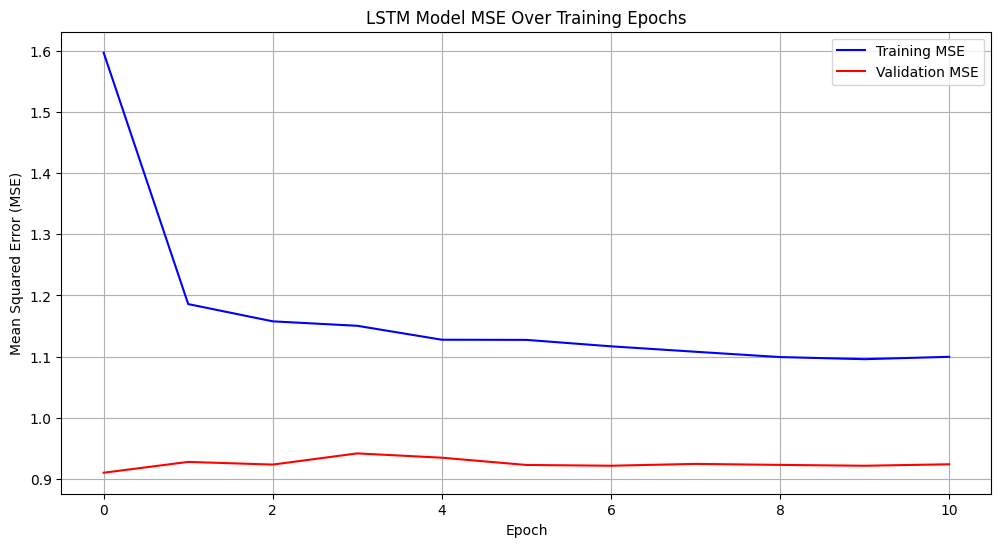

Final Training MSE: 1.0995
Final Validation MSE: 0.9236


In [18]:
# Extract MSE values from training history
train_mse = history.history['mse']  # Training MSE per epoch
val_mse = history.history['val_mse']  # Validation MSE per epoch

# Plot MSE curves
plt.figure(figsize=(12, 6))
plt.plot(train_mse, label='Training MSE', color='blue')
plt.plot(val_mse, label='Validation MSE', color='red')
plt.title('LSTM Model MSE Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print final MSE values
print(f"Final Training MSE: {train_mse[-1]:.4f}")
print(f"Final Validation MSE: {val_mse[-1]:.4f}")

Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?

A: For train dataset, the model shows steady training MSE progress, starting MSE around 1.6 (epoch 0) and final MSE around 1.0995 (final epoch). And for validation dataset, MSE is consistently around 0.92 – 0.95 with a final value of around 0.9236, indicating stability throughout training. Stable validation loss indicting, indicating good generation, no overfitting, and the model successfully learned patterns from the data.  

To improve the model, I am going to tune the following parameters:
- Add more features to training and validation data.
- Crete and add new time-based features to training and validation data.
- Modify model capacity: add more LSTM units and layers, add regularization to Dense layer, and change Optimizer learning rate,
- Change training strategies (epochs, batch size, etc.)

## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, - additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: To improve the model, I am going to tune the following parameters:
- Add more features, feat_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' + other time-based features]
- Increase model capacity:
    - Add more LSTM units and layers.
        - First LSTM layer, change units to 50.
        - Second LSTM layer, change units to 25.
        -  Dense layer, add regularization.
        - Optimizer learning rate, reduce to slower learning rate 0.001)
- Change training strategies (epochs, batch size, etc)


In [19]:
# play with your ideas for optimization here

#CREATE NEW FEATURES AND RECREATE SEQUENCE ARRAYS AND LABELS FOR TRAINING DATA
# create and add time-based features such as hour of day, day of week, etc.
train_df['hour'] = pd.to_datetime(train_df['Datetime']).dt.hour
train_df['day_of_week'] = pd.to_datetime(train_df['Datetime']).dt.dayofweek

#Convert time-based features to cyclical features
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
train_df['day_sin'] = np.sin(2 * np.pi * train_df['day_of_week'] / 7)
train_df['day_cos'] = np.cos(2 * np.pi * train_df['day_of_week'] / 7)

#reset sequence arrays and labels, then recreate them with new features
seq_arrays = []
seq_labs = []
seq_length = 30 # 30 minute input sequence
ph = 5 # 5 minute predictive horizon

#new feature columns with added time-based features
feat_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
             'Sub_metering_3', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

#create list of sequence length GAP readings
for start in range(len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].values) #get sequence of GAP readings
    seq_labs.append(train_df['Global_active_power'].iloc[start+seq_length+ph]) #get GAP reading at predictive horizon

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [20]:
seq_arrays.shape

(16359, 30, 11)

In [21]:
#Modify model architecture or hyperparameters:
#Add more LSTM layers, change number of units, adjust dropout rates, change learning rate, etc.

model_path = 'LSTM_model2.keras' #define path to save model

# build the network
nb_features = seq_arrays.shape[2] #number of features used as input
nb_out = 1 #number of outputs

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=50, #Changed number of LSTM units to 50
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=25, #Changed number of LSTM units to 25
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, kernel_regularizer=keras.regularizers.l2(0.001))) #number of output units, added L2 regularization regularization
model.add(Activation('linear')) #linear activation for regression for predicting continuous values
optimizer = keras.optimizers.Adam(learning_rate = 0.001) #Changed learning rate to 0.001
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the model with sequence arrays and labels
history = model.fit(seq_arrays, seq_labs,
                    epochs=200, #increased epochs to 200
                    batch_size=250, #smaller batch size
                    validation_split=0.05, 
                    verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

c:\Users\Loung\USD\AAI-530-IoT\AAI-530-IoT-Assignment-4.1\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,026 (78.23 KB)

 Trainable params: 20,026 (78.23 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
63/63 - 4s - 59ms/step - loss: 1.1992 - mse: 1.1971 - val_loss: 0.9265 - val_mse: 0.9244
Epoch 2/200
63/63 - 1s - 22ms/step - loss: 1.0972 - mse: 1.0951 - val_loss: 0.9266 - val_mse: 0.9245
Epoch 3/200
63/63 - 1s - 23ms/step - loss: 1.0859 - mse: 1.0838 - val_loss: 0.9230 - val_mse: 0.9209
Epoch 4/200
63/63 - 1s - 23ms/step - loss: 1.0779 - mse: 1.0758 - val_loss: 0.9154 - val_mse: 0.9133
Epoch 5/200
63/63 - 1s - 22ms/step - loss: 1.0755 - mse: 1.0734 - val_loss: 0.9087 - val_mse: 0.9066
Epoch 6/200
63/63 - 1s - 24ms/step - loss: 1.0684 - mse: 1.0663 - val_loss: 0.9251 - val_mse: 0.9230
Epoch 7/200
63/63 - 1s - 23ms/step - loss: 1.0629 - mse: 1.0608 - val_loss: 0.9149 - val_mse: 0.9128
Epoch 8/200
63/63 - 1s - 23ms/step - loss: 1.0592 - mse: 1.0571 - val_loss: 0.9097 - val_mse: 0.9077
Epoch 9/200
63/63 - 1s - 23ms/step - loss: 1.0611 - mse: 1.0591 - val_loss: 0.9328 - val_mse: 0.9308
Epoch 10/200
63/63 - 1s - 23ms/step - loss: 1.0571 - mse: 1.0551 - val_loss: 0.9156 - 

In [22]:
# CREATE NEW FEATURES AND RECREATE SEQUENCE ARRAYS AND LABELS FOR VALIDATION DATA
val_df['hour'] = pd.to_datetime(val_df['Datetime']).dt.hour
val_df['day_of_week'] = pd.to_datetime(val_df['Datetime']).dt.dayofweek

# Convert time-based features to cyclical features
val_df['hour_sin'] = np.sin(2 * np.pi * val_df['hour'] / 24)
val_df['hour_cos'] = np.cos(2 * np.pi * val_df['hour'] / 24)
val_df['day_sin'] = np.sin(2 * np.pi * val_df['day_of_week'] / 7)
val_df['day_cos'] = np.cos(2 * np.pi * val_df['day_of_week'] / 7)

val_arrays = [] # input sequences for validation data
val_labs = [] # target predictions for validation data

# new feature columns with added time-based features
feat_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
             'Sub_metering_3', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

# create list of GAP readings starting with a minimum of two readings
for seq_len in range(2, min(len(val_df), 31)):
    for start in range (len(val_df) - seq_length - ph):
        val_arrays.append(val_df[feat_cols].iloc[start:start+seq_length].values) # get sequence of GAP readings
        val_labs.append(val_df['Global_active_power'].iloc[start+seq_length+ph]) # get GAP reading at predictive horizon

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = keras.utils.pad_sequences(val_arrays, maxlen=seq_length, padding='pre', value=0.0) # pad with zeros at the beginning
        
# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

print(f"Validation arrays shape: {val_arrays.shape}")
print(f"Validation labels shape: {val_labs.shape}")
print(f"Number of features: {val_arrays.shape[2]}")

Validation arrays shape: (117856, 30, 11)
Validation labels shape: (117856,)
Number of features: 11


In [26]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above

## Validate the optimized model

3683/3683 - 11s - 3ms/step - loss: 1.1215 - mse: 1.1196

MSE: 1.119554042816162
3683/3683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


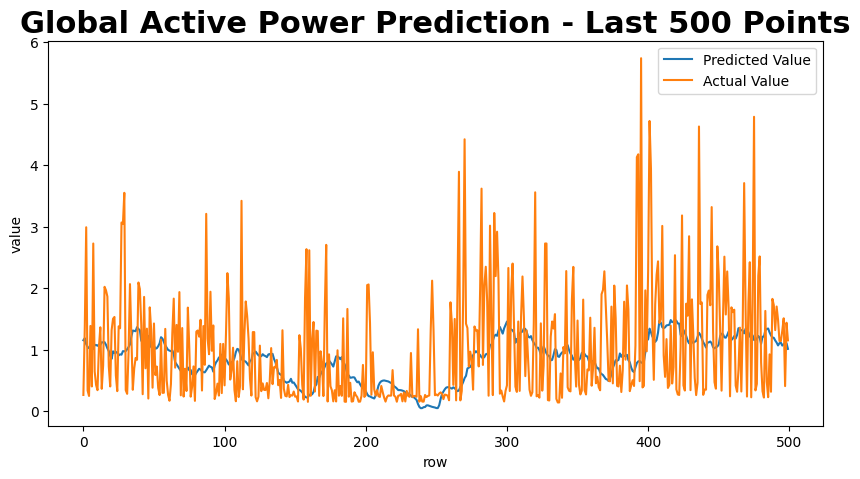

In [23]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None) #save predictions to csv file

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

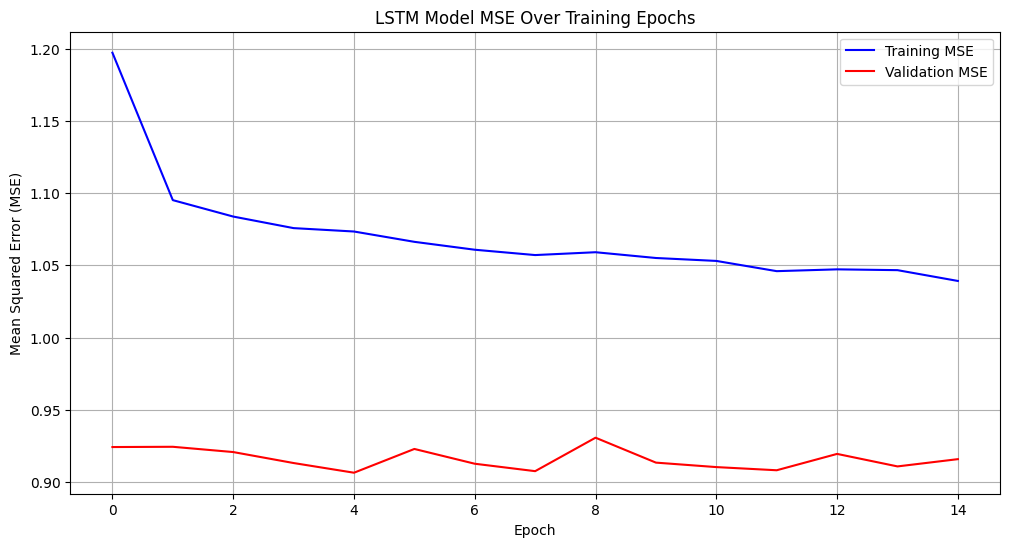

Final Training MSE: 1.0392
Final Validation MSE: 0.9160


In [24]:
# Extract MSE values from training history
train_mse = history.history['mse']  # Training MSE per epoch
val_mse = history.history['val_mse']  # Validation MSE per epoch

# Plot MSE curves
plt.figure(figsize=(12, 6))
plt.plot(train_mse, label='Training MSE', color='blue')
plt.plot(val_mse, label='Validation MSE', color='red')
plt.title('LSTM Model MSE Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Print final MSE values
print(f"Final Training MSE: {train_mse[-1]:.4f}")
print(f"Final Validation MSE: {val_mse[-1]:.4f}")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The optimized model shows significant improvement over the original model. The model demonstrates steady training MSE progress, starting around 1.2 at epoch 0 and achieving a final MSE of approximately 1.039 at the final epoch. For the validation dataset, the MSE consistently remains below 0.95 with a final value of around 0.9160, indicating good generalization, no overfitting, and successful pattern learning from the data.

The improvements were effective due to several key changes:
1. **Additional features**: Adding time-based features (hour_sin, hour_cos, day_sin, day_cos) and all power-related features helped the model capture temporal patterns and relationships between different power measurements.
2. **Increased model capacity**: Using 50 and 25 LSTM units (vs. 5 and 3 originally) provided more learning capacity.
3. **Better regularization**: L2 regularization in the Dense layer helped prevent overfitting.
4. **Optimized training**: Lower learning rate (0.001) and adjusted batch size improved convergence.

For production optimization, I would try:
- Hyperparameter tuning using grid search or Bayesian optimization
- Ensemble methods combining multiple models
- Advanced architectures like attention mechanisms or transformer layers
- Feature engineering based on domain expertise (seasonal patterns, weather data)

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Comparison between LSTM and Linear Regression models:

Linear Regression Performance Summary from Assignment 3.1:
- Univariate model (Time only): MSE = 0.5804 (baseline)
- Bivariate model (Time + Voltage): MSE = 0.5748 (+0.96% improvement)
- Multivariate model (Time + Voltage + Global Intensity): MSE = 0.5457 (+5.97% improvement)

LSTM Performance Summary:
- Original LSTM model:
  - Train MSE ~ 1.6 – 1.1
  - Valid MSE ~ 0.9236 (final)
- Optimized LSTM model:
  - Train MSE ~ 1.2 – 1.0392
  - Valid MSE ~ 0.9160 (final)

Based on the results, linear regression model achieved significantly better MSE performance as compared to the LSTM model. The linear regression shows clear benefit from additional features, with Global Intensity providing the most substantial improvement (+5.97%).

For an IoT system predicting GAP with a 5-minute horizon, I would choose the **Linear Regression model** because it achieved better accuracy and easy to implement:
1. **Resource Constraints**: IoT devices typically have limited memory and processing power
2. **Real-time Requirements**: 5-minute predictions need fast, reliable responses.
3. **Energy Efficiency**: Lower power consumption is critical for battery-powered IoT devices.
4. **Maintenance**: Simpler models are easier to deploy, monitor, and update in production.
The LSTM model would be better suited for cloud-based analytics or edge computing scenarios where computational resources are less constrained. 
